In [2]:
import gaia_roman_combined as grc

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

import astropy
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u

#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)


In [3]:
#define some default values

roman_pos_err_floor = 0.01*grc.roman_pix_scale #mas, floor or pos uncertainty, (standard is 1% pixel)
gaia_era = 'DR4' #choose from ['DR3','DR4','DR5']

print(f'Currently Using a Roman position uncertainty floor of {roman_pos_err_floor} mas')

print()

print('Allowed Roman filters are:',grc.allowed_filters)

print()
print('Allowed Roman MultiAccum choices are:')
print('#MA_Name            Exposure Time (seconds)')
for ma_name in grc.allowed_ma_names:
    print(f'{ma_name:20s}{round(grc.ma_integration_times[ma_name],1)}')


Currently Using a Roman position uncertainty floor of 1.078577405 mas

Allowed Roman filters are: ['F062', 'F087', 'F106', 'F129', 'F146', 'F158', 'F184', 'F213']

Allowed Roman MultiAccum choices are:
#MA_Name            Exposure Time (seconds)
C1_IMG_MICROLENS    56.9
C2A_IMG_HLWAS       139.1
C2B_IMG_HLWAS       199.2
C2C_IMG_HLWAS       294.1
C2D_IMG_HLWAS       395.3
C2E_IMG_HLWAS       493.3
C2F_IMG_HLWAS       591.4
C2G_IMG_HLWAS       736.9
C2H_IMG_HLWAS       975.6


In [6]:
'''
Example of how to measure the improved astrometry from combining Roman and Gaia
for the HLTDS. 
'''

#example with 100 magnitudes
n_stars = 100

#Get the new precision from this configuration of
#magnitudes and observing plans. 
#NOTE: specifying ra and dec mean that parallax is used in 
#the calculation. Leaving the ra and dec as None will
#only use positions and PMs in the calculation.

#HLTDS
ra,dec = 242.504,54.510 #ELAIS-N1 Field
ra,dec = 61.241,-48.423 #Euclid Deep Field

# F062 (R), F087 (Z), F106 (Y), F129 (J),
# F146 (wide), F158 (H), F184 (H/K), F213 (Ks)

# 'RZY'
# 'RJH'

#HLTDS
roman_filters = ['F062','F129'] #R,J, good case
# roman_filters = ['F184','F213'] #Z,K, bad case
pilot_times = Time(2027.5,format='jyear')+np.arange(0,8,1)*20*u.day
core_times = Time(2027.5+2.5,format='jyear')+np.arange(-1*365,1*365,5)*u.day
extended_times_early = pilot_times.max()+np.arange(1,3+1,1)*120*u.day
extended_times_late = core_times.max()+np.arange(1,5+1,1)*120*u.day
epoch_MJDs = np.sort(np.concatenate((pilot_times.mjd,extended_times_early.mjd,core_times.mjd,extended_times_late.mjd)))

epoch_filters = np.array(roman_filters)[np.arange(len(epoch_MJDs))%2] 
n_images_per_epoch = np.ones(len(epoch_MJDs)).astype(int)*3

epoch_MAs = ['C2C_IMG_HLWAS']*len(epoch_MJDs) #Roman MultiAccum names for that observation (i.e. exposure times)

#build the observation list using the above data
observation_list = list(zip(epoch_MJDs,epoch_filters,n_images_per_epoch,epoch_MAs))

#array that contains the Roman magnitudes in each filter.
#
#assuming color of stars in all filters is 0 and zeropoint with Gaia is also 0
roman_mags = np.zeros((n_stars,len(roman_filters))) 
roman_mags[:] = np.linspace(16,29.5,n_stars)[:,None]         #AB mags
gaia_mags = roman_mags[:,0]

new_precision = grc.gaia_roman_astrometric_precision(
    roman_mags = roman_mags,
    roman_filters = roman_filters,
    gaia_mags = gaia_mags,
    observation_list = observation_list,
    gaia_era = 'DR5',
    ra = ra, dec = dec,
)








/opt/anaconda3/envs/roman_test/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2430: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/roman_test/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 151 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/envs/roman_test/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 151 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_11171/2394483860.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


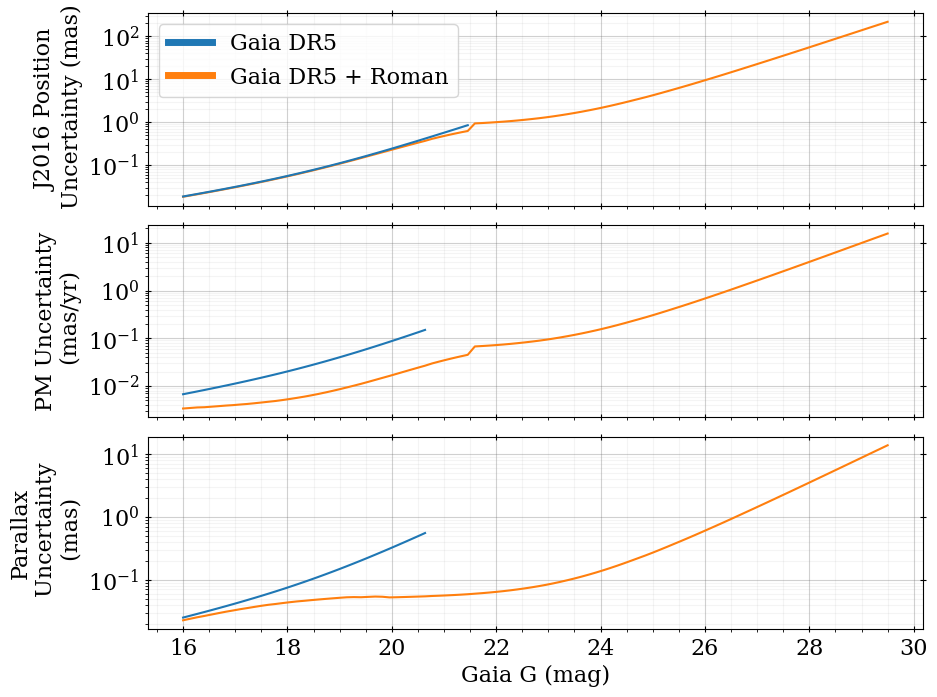

In [7]:


plt.figure(figsize=(10,8))

gs = gridspec.GridSpec(3,1,hspace=0.1)
ax = plt.subplot(gs[0])    


# ax = plt.gca()
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_pos_errs,label=f'Gaia {new_precision.gaia_era}',zorder=10)
plt.plot(new_precision.gaia_gs,new_precision.final_pos_errs,label=f'Gaia {new_precision.gaia_era} + Roman')
# plt.xlabel('Gaia G (mag)')
plt.ylabel('J2016 Position\n Uncertainty (mas)')
leg = plt.legend(loc='best')
for line in leg.get_lines():
    line.set_linewidth(5.0)
ax.set_xticklabels([])
# plt.show()

# plt.figure(figsize=(10,5))
# ax = plt.gca()
ax = plt.subplot(gs[1])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_pm_errs,label=f'Gaia {new_precision.gaia_era}',zorder=10)
plt.plot(new_precision.gaia_gs,new_precision.final_pm_errs,label=f'Gaia {new_precision.gaia_era} + Roman')
# plt.xlabel('Gaia G (mag)')
plt.ylabel('PM Uncertainty\n (mas/yr)')
ax.set_xticklabels([])
# leg = plt.legend(loc='best')
# for line in leg.get_lines():
#     line.set_linewidth(5.0)
# plt.show()

# plt.figure(figsize=(10,5))
# ax = plt.gca()
ax = plt.subplot(gs[2])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_parallax_errs,label=f'Gaia {new_precision.gaia_era}',zorder=10)
plt.plot(new_precision.gaia_gs,new_precision.final_parallax_errs,label=f'Gaia {new_precision.gaia_era} + Roman')
plt.xlabel('Gaia G (mag)')
plt.ylabel('Parallax\n Uncertainty\n (mas)')
# leg = plt.legend(loc='best')
# for line in leg.get_lines():
#     line.set_linewidth(5.0)
plt.tight_layout()
plt.show()




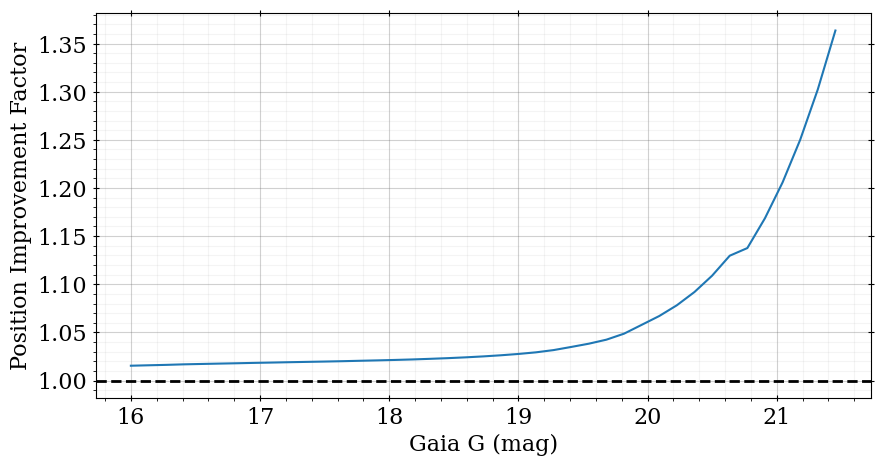

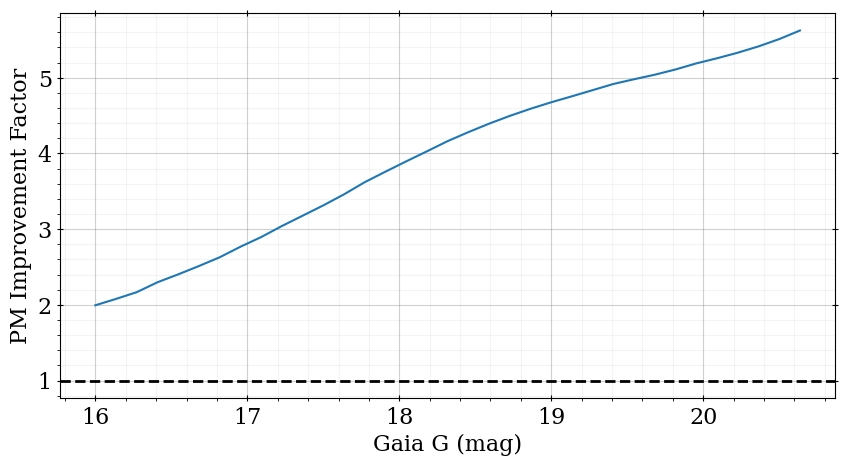

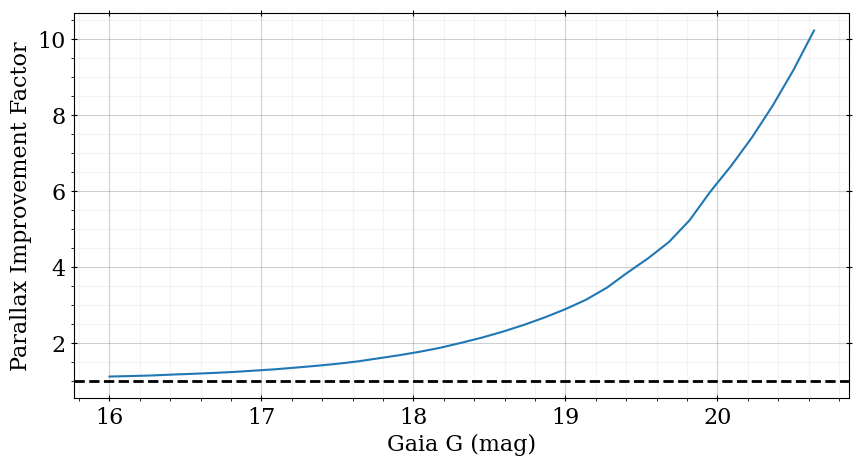

In [11]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.axhline(1.0,c='k',lw=2,ls='--')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_pos_errs/new_precision.final_pos_errs)
plt.xlabel('Gaia G (mag)')
plt.ylabel(r'Position Improvement Factor')
plt.show()

plt.figure(figsize=(10,5))
ax = plt.gca()
plt.axhline(1.0,c='k',lw=2,ls='--')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_pm_errs/new_precision.final_pm_errs)
plt.xlabel('Gaia G (mag)')
plt.ylabel(r'PM Improvement Factor')
plt.show()

plt.figure(figsize=(10,5))
ax = plt.gca()
plt.axhline(1.0,c='k',lw=2,ls='--')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_parallax_errs/new_precision.final_parallax_errs)
plt.xlabel('Gaia G (mag)')
plt.ylabel(r'Parallax Improvement Factor')
plt.show()


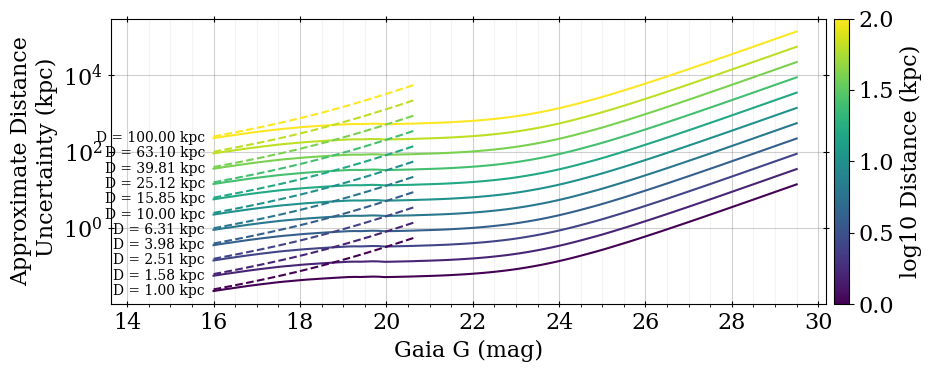

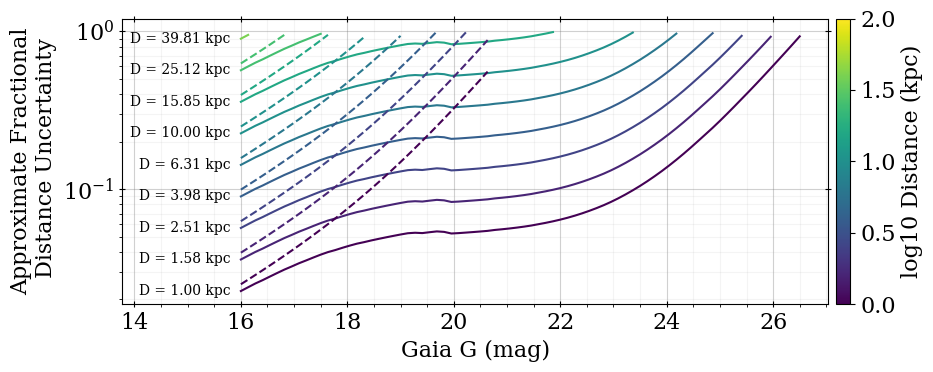

In [8]:
distances = np.logspace(1,1,1)
distances = np.logspace(0,2,11)

cm = matplotlib.cm.viridis
norm = matplotlib.colors.Normalize(vmin=np.log10(distances.min()),vmax=np.log10(distances.max()))
# create a ScalarMappable and initialize a data structure
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])


plt.figure(figsize=(10,4))
ax = plt.gca()
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
for dist_ind,dist in enumerate(distances):
    plt.plot(new_precision.gaia_gs,new_precision.gaia_parallax_errs*dist**2,
             zorder=10,ls='--',
             color=sm.to_rgba(np.log10(dist)))
    plt.plot(new_precision.gaia_gs,new_precision.final_parallax_errs*dist**2,
             color=sm.to_rgba(np.log10(dist)))
    # plt.text(new_precision.gaia_gs[0]-0.2,new_precision.final_parallax_errs[0]*dist**2,
    #          'D = %.2f kpc'%(dist),ha='right',va='center',
    #          fontsize=10,color=sm.to_rgba(np.log10(dist)))
    plt.text(new_precision.gaia_gs[0]-0.2,new_precision.final_parallax_errs[0]*dist**2,
             'D = %.2f kpc'%(dist),ha='right',va='center',
             fontsize=10,color='k')
plt.colorbar(sm, ax=ax,label=r'log10 Distance (kpc)',pad=0.01)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Approximate Distance\n Uncertainty (kpc)')
# leg = plt.legend(loc='best')
# for line in leg.get_lines():
#     line.set_linewidth(5.0)
xlim = np.array(ax.get_xlim())
xlim[0] -= 1.7
ax.set_xlim(xlim)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
ax = plt.gca()
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
for dist_ind,dist in enumerate(distances):
    keep = new_precision.gaia_parallax_errs*dist < 1
    plt.plot(new_precision.gaia_gs[keep],(new_precision.gaia_parallax_errs*dist)[keep],
             zorder=10,ls='--',
             color=sm.to_rgba(np.log10(dist)))
    keep = new_precision.final_parallax_errs*dist < 1
    plt.plot(new_precision.gaia_gs[keep],(new_precision.final_parallax_errs*dist)[keep],
             color=sm.to_rgba(np.log10(dist)))

    # keep = np.ones(len(new_precision.gaia_gs)).astype(bool)
    # plt.plot(new_precision.gaia_gs[keep],(new_precision.gaia_parallax_errs*dist)[keep],
    #          zorder=10,ls='--',
    #          color=sm.to_rgba(np.log10(dist)))
    # plt.plot(new_precision.gaia_gs[keep],(new_precision.final_parallax_errs*dist)[keep],
    #          color=sm.to_rgba(np.log10(dist)))

    if np.sum(keep) > 0:
        plt.text(new_precision.gaia_gs[0]-0.2,new_precision.final_parallax_errs[0]*dist,
                 'D = %.2f kpc'%(dist),ha='right',va='center',
                 fontsize=10,color='k')
        # plt.text(new_precision.gaia_gs[0]-0.2,new_precision.final_parallax_errs[0]*dist,
        #          'D = %.2f kpc'%(dist),ha='right',va='center',
        #          fontsize=10,color=sm.to_rgba(np.log10(dist)))
xlim = np.array(ax.get_xlim())
xlim[0] -= 1.7
ax.set_xlim(xlim)
plt.colorbar(sm, ax=ax,label=r'log10 Distance (kpc)',pad=0.01)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Approximate Fractional\n Distance Uncertainty')
# leg = plt.legend(loc='best')
# for line in leg.get_lines():
#     line.set_linewidth(5.0)
plt.tight_layout()
plt.show()


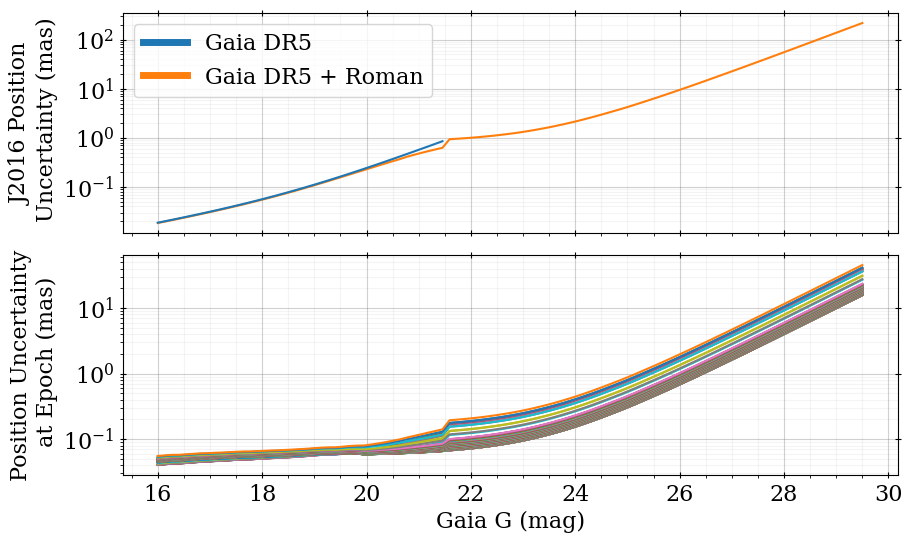

In [9]:
pos_covs_at_epochs = np.einsum('tij,tsjk->tsik',new_precision.motion_matrices,
          np.einsum('sij,tkj->tsik',new_precision.final_astrometry_covs,
                    new_precision.motion_matrices))
pos_errs_at_epochs = np.power(np.linalg.det(pos_covs_at_epochs),1/4)
obs_jyears = new_precision.obs_times.jyear


plt.figure(figsize=(10,6))

gs = gridspec.GridSpec(2,1,hspace=0.1)
ax = plt.subplot(gs[0])    

# ax = plt.gca()
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_pos_errs,label=f'Gaia {new_precision.gaia_era}',zorder=10)
plt.plot(new_precision.gaia_gs,new_precision.final_pos_errs,label=f'Gaia {new_precision.gaia_era} + Roman')
# plt.xlabel('Gaia G (mag)')
plt.ylabel('J2016 Position\n Uncertainty (mas)')
leg = plt.legend(loc='best')
for line in leg.get_lines():
    line.set_linewidth(5.0)
ax.set_xticklabels([])

ax = plt.subplot(gs[1])    
# plt.figure(figsize=(10,5))
# ax = plt.gca()
ax.set_yscale('log')
# plt.axhline(1.0,c='k',lw=2,ls='--')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
for j in range(len(obs_jyears)):
    plt.plot(new_precision.gaia_gs,pos_errs_at_epochs[j],label='J%.1f'%obs_jyears[j])
# leg = plt.legend(loc='best')
# for line in leg.get_lines():
#     line.set_linewidth(5.0)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Position Uncertainty\n at Epoch (mas)')
plt.show()



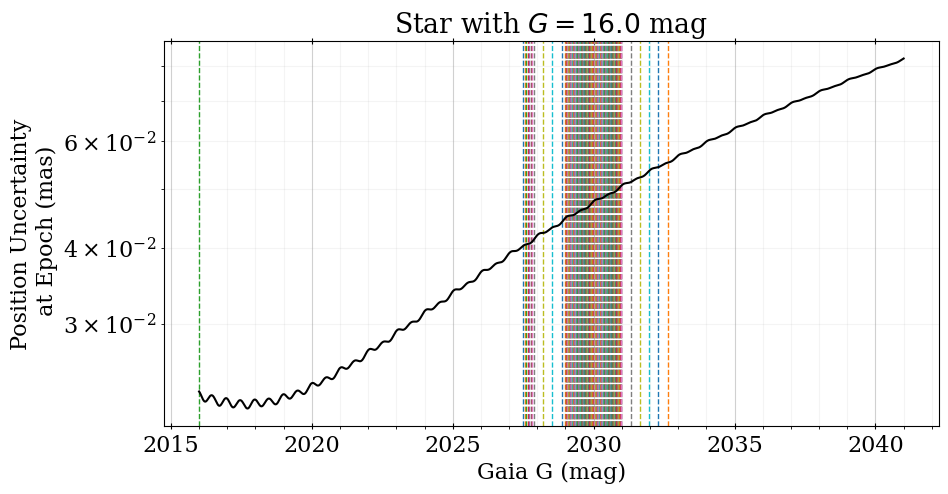

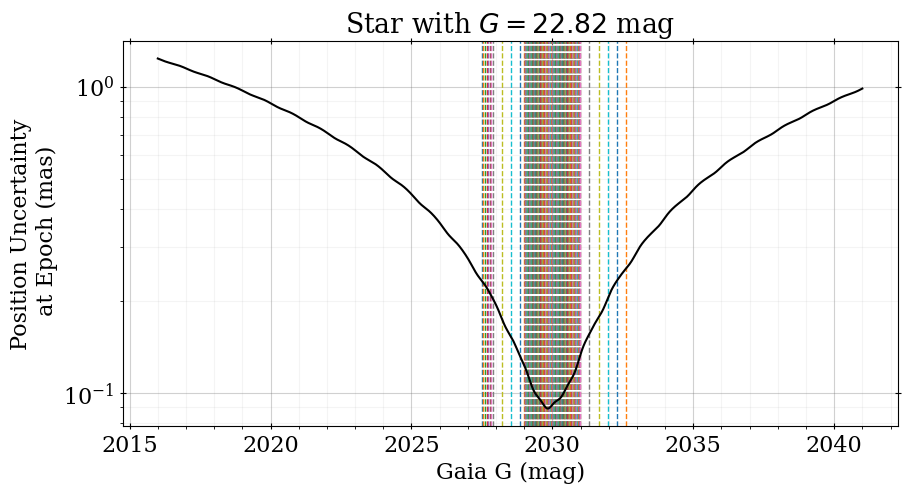

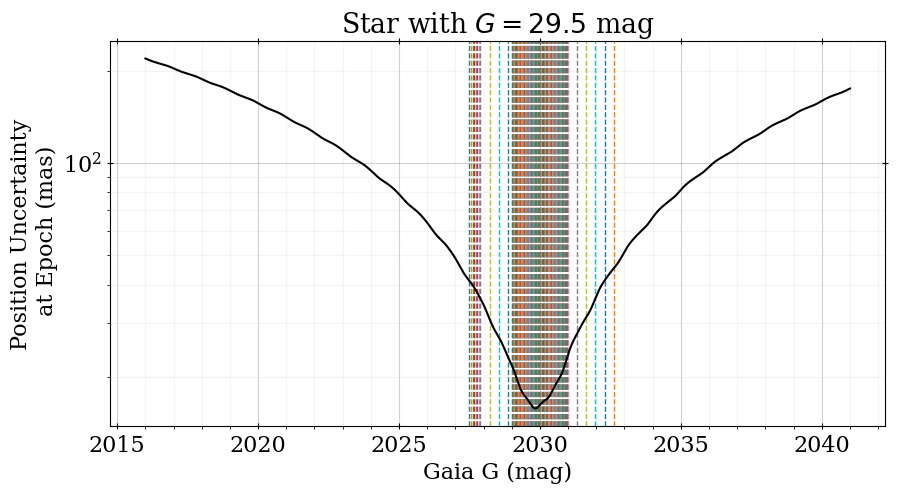

In [10]:
pos_errs_per_roman_epoch = (np.sqrt(np.power(new_precision.roman_pos_errs,2)+(0.01*grc.roman_pix_scale)**2)[:,new_precision.obs_roman_filt_inds]\
                                    /np.sqrt(new_precision.obs_n_images_per_epoch[None,:]))
new_epoch_times = new_precision.gaia_time+np.linspace(0,25,2000)*u.year
# new_epoch_times = new_precision.gaia_time+np.linspace(0,100,200)*u.year
new_dyears = (new_epoch_times-new_precision.gaia_time).to(u.year).value
new_parallax_vectors = grc.delta_ra_dec_per_parallax_VECTORIZED(new_epoch_times,new_precision.gaia_time,ra,dec)
#motion_matrix dot [dracosdec,ddec,pmracosdec,pmdec,] = position change
new_motion_matrices = np.zeros((len(new_epoch_times),2,5))
new_motion_matrices[:,0,0] = -1
new_motion_matrices[:,1,1] = -1
new_motion_matrices[:,0,2] = -new_dyears
new_motion_matrices[:,1,3] = -new_dyears
new_motion_matrices[:,0,4] = -new_parallax_vectors[:,0]
new_motion_matrices[:,1,4] = -new_parallax_vectors[:,1]

new_pos_covs_at_epochs = np.einsum('tij,tsjk->tsik',new_motion_matrices,
          np.einsum('sij,tkj->tsik',new_precision.final_astrometry_covs,
                    new_motion_matrices))
new_pos_errs_at_epochs = np.power(np.linalg.det(new_pos_covs_at_epochs),1/4)
new_obs_jyears = new_epoch_times.jyear

star_ind = -1
star_ind = 0
for star_ind in [0,len(pos_errs_per_roman_epoch)//2,len(pos_errs_per_roman_epoch)-1]:
    plt.figure(figsize=(10,5))
    ax = plt.gca()
    ax.set_yscale('log')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
    ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
    
    for time_ind,time in enumerate(new_precision.obs_times.jyear):
        filt = new_precision.roman_filters[new_precision.obs_roman_filt_inds[time_ind]]
        plt.axvline(time,lw=1,ls='--',c='C%d'%(time_ind))
        # plt.axhline(pos_errs_per_roman_epoch[star_ind,time_ind],lw=1,ls='-',c='C%d'%(time_ind),label='J%.1f, %s'%(time,filt))
    time_ind += 1
    time = new_precision.gaia_time.jyear
    if new_precision.good_gaia_pos[star_ind]:
        plt.axvline(time,lw=1,ls='--',c='C%d'%(time_ind))
        # plt.axhline(new_precision.gaia_pos_errs[star_ind],lw=1,ls='-',c='C%d'%(time_ind),label=f'Gaia {new_precision.gaia_era}')
    
    # leg = plt.legend(loc='best')
    # for line in leg.get_lines():
    #     line.set_linewidth(5.0)
    
    plt.title(f'Star with $G = {round(new_precision.gaia_gs[star_ind],2)}$ mag')
    plt.plot(new_obs_jyears,new_pos_errs_at_epochs[:,star_ind],c='k')
    plt.xlabel('Gaia G (mag)')
    plt.ylabel('Position Uncertainty\n at Epoch (mas)')
    plt.show()
    
